<a href="https://www.kaggle.com/code/quangnguynngnht/incremental-learning-with-svd-based-algorithms?scriptVersionId=179719351" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install scikit-surprise
# %pip install joblib

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from sklearn.metrics import roc_auc_score
import zipfile
import os
import gc

In [3]:
# Function to read a single data file and return a DataFrame
def read_data_file(file_path):
    data_list = []
    with open(file_path, 'r') as file:
        current_movie_id = None
        for line in file:
            line = line.strip()
            if line.endswith(':'):
                current_movie_id = int(line.replace(':', ''))
            else:
                customer_id, rating, date = line.split(',')
                data_list.append([int(customer_id), current_movie_id, float(rating), date])
    return pd.DataFrame(data_list, columns=['Cust_Id', 'Movie_Id', 'Rating', 'Date'])

In [4]:
# Function to filter out inactive users based on the specified quantile threshold
def filter_active_users(ratings, quantile_threshold=0.6):
    ratings_count = ratings['Cust_Id'].value_counts()
    active_users = ratings_count[ratings_count >= ratings_count.quantile(quantile_threshold)].index
    return ratings[ratings['Cust_Id'].isin(active_users)]

In [5]:
# Function to prepare data for the Surprise library
def prepare_data_for_surprise(ratings):
    reader = Reader(rating_scale=(1, 5))
    return Dataset.load_from_df(ratings[['Cust_Id', 'Movie_Id', 'Rating']], reader)

In [6]:
# List of combined data files
data_files = [
    'combined_data_1.txt',
    'combined_data_2.txt',
    'combined_data_3.txt',
    'combined_data_4.txt'
]

In [7]:
# Load data from the first file for EDA
train_ratings_1 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[0]))

# Load data from the second file for EDA
train_ratings_2 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[1]))

# Load data from the third file for EDA
train_ratings_3 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[2]))

# Load data from the fourth file for EDA
train_ratings_4 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[3]))


In [8]:
# Concatenate EDA data
train_ratings = pd.concat([train_ratings_1, train_ratings_2, train_ratings_3, train_ratings_4])
print(train_ratings.head())

   Cust_Id  Movie_Id  Rating        Date
0  1488844         1     3.0  2005-09-06
1   822109         1     5.0  2005-05-13
2   885013         1     4.0  2005-10-19
3    30878         1     4.0  2005-12-26
4   823519         1     3.0  2004-05-03


In [9]:
del train_ratings_3
del train_ratings_4

In [10]:
# Filter inactive users from EDA data
train_ratings = filter_active_users(train_ratings)
print(train_ratings.shape)

(84782963, 4)


In [11]:
# Basic statistics for EDA data
print(train_ratings.describe())

            Cust_Id      Movie_Id        Rating
count  8.478296e+07  8.478296e+07  8.478296e+07
mean   1.322157e+06  9.036874e+03  3.587963e+00
std    7.643524e+05  5.132874e+03  1.075015e+00
min    6.000000e+00  1.000000e+00  1.000000e+00
25%    6.617310e+05  4.656000e+03  3.000000e+00
50%    1.318179e+06  8.989000e+03  4.000000e+00
75%    1.983888e+06  1.360200e+04  4.000000e+00
max    2.649429e+06  1.777000e+04  5.000000e+00


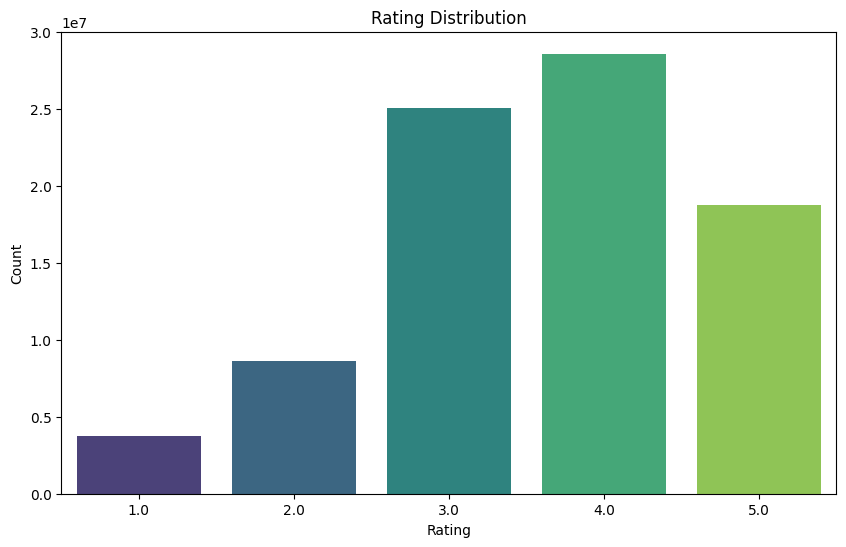

In [12]:
# Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_ratings, x='Rating', palette='viridis')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


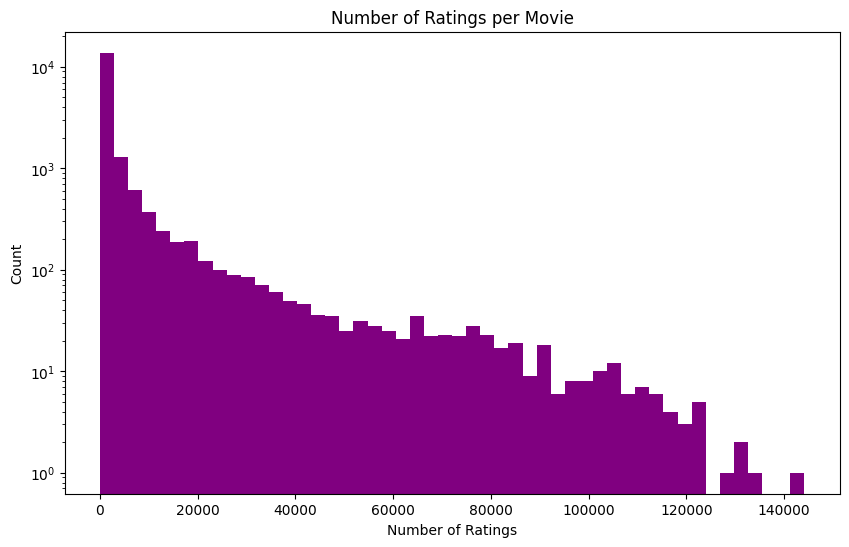

In [13]:
# Number of ratings per movie
ratings_per_movie = train_ratings.groupby('Movie_Id').size()
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_movie, bins=50, color='purple')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

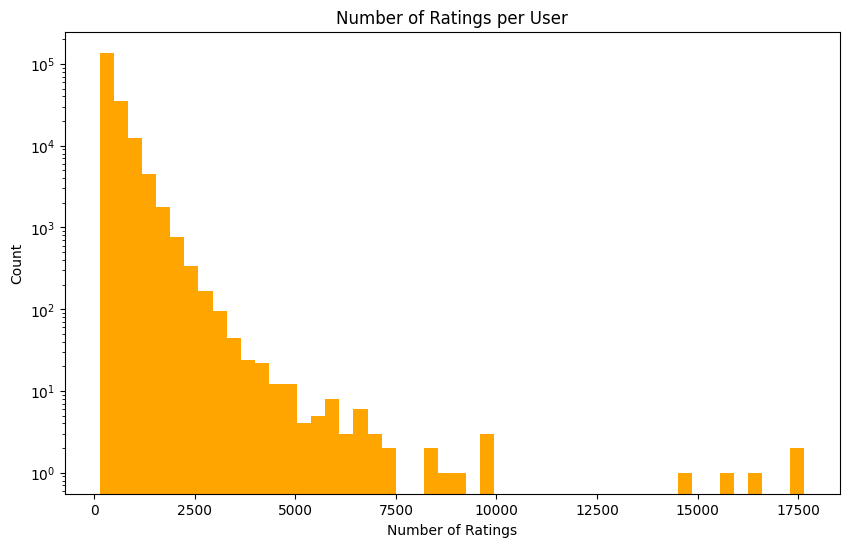

In [14]:
# Number of ratings per user
ratings_per_user = train_ratings.groupby('Cust_Id').size()
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_user, bins=50, color='orange')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [15]:
# Concatenate training data - batch 1
train_ratings = pd.concat([train_ratings_1, train_ratings_2])

print(train_ratings.head())

   Cust_Id  Movie_Id  Rating        Date
0  1488844         1     3.0  2005-09-06
1   822109         1     5.0  2005-05-13
2   885013         1     4.0  2005-10-19
3    30878         1     4.0  2005-12-26
4   823519         1     3.0  2004-05-03


In [16]:
del train_ratings_1
del train_ratings_2

In [17]:
# Filter inactive users from training data - batch 1
train_ratings = filter_active_users(train_ratings)
print(train_ratings.shape)


(43385287, 4)


In [18]:
# Basic statistics for training data - batch 1
print(train_ratings.describe())


            Cust_Id      Movie_Id        Rating
count  4.338529e+07  4.338529e+07  4.338529e+07
mean   1.322094e+06  4.657718e+03  3.578260e+00
std    7.644242e+05  2.592468e+03  1.075539e+00
min    6.000000e+00  1.000000e+00  1.000000e+00
25%    6.616630e+05  2.443000e+03  3.000000e+00
50%    1.318029e+06  4.727000e+03  4.000000e+00
75%    1.984086e+06  6.833000e+03  4.000000e+00
max    2.649429e+06  9.210000e+03  5.000000e+00


In [19]:
# Prepare batch 1 training data for the Surprise library
train_data = prepare_data_for_surprise(train_ratings)

In [20]:
del train_ratings

In [21]:
# Split the batch 1 training data into train and validation sets
trainset, valset = train_test_split(train_data, test_size=0.25)


In [22]:
del train_data

In [23]:
# Define the SVD model
algo = SVD(n_epochs=10)

In [24]:
# Train the SVD model
algo.fit(trainset)

In [25]:
# Evaluate the initial model
val_predictions = algo.test(valset)
val_rmse = accuracy.rmse(val_predictions)
val_mae = accuracy.mae(val_predictions)
print(f'Validation RMSE: {val_rmse}, Validation MAE: {val_mae}')

RMSE: 0.8518
MAE:  0.6615
Validation RMSE: 0.8517740500245785, Validation MAE: 0.6615047848966312


In [26]:
# Clear unnecessary data structures to free up memory
del trainset
del valset
del val_predictions

gc.collect()

0

In [27]:
# Save the trained model to a file
model_filename = 'svd_model.joblib'
joblib.dump(algo, model_filename)
print(f"Model saved to {model_filename}")

Model saved to svd_model.joblib


In [28]:
# Load the saved model
model_filename = 'svd_model.joblib'
algo = joblib.load(model_filename)
print("Model loaded successfully")

Model loaded successfully


In [29]:
# Load additional data files for batch 2
train_ratings_3 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[2]))
train_ratings_4 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[3]))

In [30]:
# Concatenate the batch 2 data
additional_ratings = pd.concat([train_ratings_3, train_ratings_4])

In [31]:
del train_ratings_3
del train_ratings_4

In [32]:
# Filter inactive users from batch 2 training data
additional_ratings = filter_active_users(additional_ratings)
print(additional_ratings.shape)

(41405200, 4)


In [33]:
# Basic statistics for batch 2 data
print(additional_ratings.describe())

            Cust_Id      Movie_Id        Rating
count  4.140520e+07  4.140520e+07  4.140520e+07
mean   1.322295e+06  1.361632e+04  3.598308e+00
std    7.643678e+05  2.418434e+03  1.074407e+00
min    6.000000e+00  9.211000e+03  1.000000e+00
25%    6.617300e+05  1.152100e+04  3.000000e+00
50%    1.318390e+06  1.370500e+04  4.000000e+00
75%    1.984086e+06  1.567100e+04  4.000000e+00
max    2.649429e+06  1.777000e+04  5.000000e+00


In [34]:
# Prepare batch 2 data for the Surprise library
additional_data = prepare_data_for_surprise(additional_ratings)

In [35]:
del additional_ratings

In [36]:
# Split the batch 2 data into train and validation sets
additional_trainset, additional_valset = train_test_split(additional_data, test_size=0.25)

In [37]:
del additional_data

In [38]:
# Train the model incrementally with batch 2 data
algo.fit(additional_trainset)

In [39]:
# Evaluate the model
additional_val_predictions = algo.test(additional_valset)
additional_val_rmse = accuracy.rmse(additional_val_predictions)
additional_val_mae = accuracy.mae(additional_val_predictions)
print(f'Additional Validation RMSE: {additional_val_rmse}, Additional Validation MAE: {additional_val_mae}')

RMSE: 0.8525
MAE:  0.6623
Additional Validation RMSE: 0.852473858664471, Additional Validation MAE: 0.6622886615677068


In [40]:
# Extract true labels and predicted scores
true_labels = [pred.r_ui for pred in additional_val_predictions]
predicted_scores = [pred.est for pred in additional_val_predictions]

In [41]:
# Function to calculate DCG@k
def dcg_at_k(relevance_scores, k):
    relevance_scores = np.asfarray(relevance_scores)[:k]
    if relevance_scores.size:
        return np.sum(relevance_scores / np.log2(np.arange(2, relevance_scores.size + 2)))
    return 0.

# Function to calculate nDCG@k
def ndcg_at_k(relevance_scores, k):
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)
    return dcg_at_k(relevance_scores, k) / dcg_at_k(ideal_relevance_scores, k)

In [42]:
# Calculate the total number of relevant items
total_relevant_items = sum([1 for label in true_labels if label >= 4])

# Calculate nDCG@10 and nDCG@100
k_values = [10, 100]
ndcg_scores = {k: ndcg_at_k(true_labels, k) for k in k_values}

print(f"nDCG@10: {ndcg_scores[10]}")
print(f"nDCG@100: {ndcg_scores[100]}")

nDCG@10: 0.7255329048782583
nDCG@100: 0.7564810580550584


In [43]:
# Ensure true_labels are binary for AUC calculation
binary_true_labels = [1 if label >= 4 else 0 for label in true_labels]

# Calculate AUC
auc = roc_auc_score(binary_true_labels, predicted_scores)
print(f"AUC: {auc}")

AUC: 0.808487401765462


In [44]:
# Clear unnecessary data structures to free up memory
del additional_trainset
del additional_valset

gc.collect()

0

In [45]:
# Save the updated model
updated_model_filename = 'svd_model_updated.joblib'
joblib.dump(algo, updated_model_filename)
print(f"Updated model saved to {updated_model_filename}")

Updated model saved to svd_model_updated.joblib


In [46]:
# Path to the model file
model_filename = 'svd_model_updated.joblib'

# Name of the zip file
zip_filename = 'svd_model.zip'

# Create a zip file and add the model file to it
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write(model_filename)

print(f"Model has been zipped and saved as {zip_filename}")


Model has been zipped and saved as svd_model.zip


In [47]:
# Load the saved model
updated_model_filename = 'svd_model_updated.joblib'
algo = joblib.load(updated_model_filename)
print("Model loaded successfully")

Model loaded successfully


In [48]:
# Function to get top-N recommendations for a user
def get_top_n_recommendations(algo, user_id, movie_ids, n=10):
    # Create a list of (movie_id, predicted_rating) for all movies
    predictions = [algo.predict(user_id, str(movie_id)) for movie_id in movie_ids]
    
    # Sort the predictions by estimated rating in descending order
    top_n_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Extract the movie IDs and estimated scores from the top-N predictions
    top_n_movie_ids = [int(pred.iid) for pred in top_n_predictions]
    top_n_scores = [pred.est for pred in top_n_predictions]
    
    return top_n_movie_ids, top_n_scores

In [49]:
# Load movie titles with custom parser to handle inconsistent number of columns
def read_movie_titles(file_path):
    movie_titles = []
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        for line in file:
            parts = line.strip().split(',', 2)
            if len(parts) == 3:
                movie_id, year, name = parts
                try:
                    movie_id = int(movie_id)
                except ValueError:
                    continue
                if year == 'NULL':
                    year = None
                else:
                    try:
                        year = int(year)
                    except ValueError:
                        continue
                movie_titles.append([movie_id, year, name])
    return pd.DataFrame(movie_titles, columns=['Movie_Id', 'Year', 'Name'])

movie_titles = read_movie_titles('/kaggle/input/netflix-prize-data/movie_titles.csv')

In [50]:
# Get all movie IDs from the movie titles dataset
all_movie_ids = movie_titles['Movie_Id'].unique()

In [51]:
# Load the qualifying dataset
def read_qualifying_file(file_path):
    qualifying_data = []
    current_movie_id = None
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.endswith(':'):
                current_movie_id = int(line.replace(':', ''))
            else:
                customer_id, date = line.split(',')
                qualifying_data.append([int(customer_id), current_movie_id])
    return pd.DataFrame(qualifying_data, columns=['Cust_Id', 'Movie_Id'])

qualifying_data = read_qualifying_file('/kaggle/input/netflix-prize-data/qualifying.txt')

In [52]:
# Get unique user IDs from the qualifying dataset
unique_user_ids = qualifying_data['Cust_Id'].unique()

In [53]:
# Function to get top-N recommendations for a user
def get_top_n_recommendations_for_user(user_id, algo, movie_ids, n=10):
    predictions = [algo.predict(user_id, movie_id) for movie_id in movie_ids]
    top_n_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    return [(user_id, int(pred.iid), pred.est) for pred in top_n_predictions]

# Function to generate predictions for a single user
def generate_predictions_for_specific_user(user_id, algo, movie_ids, n=10):
    # Generate predictions for all movies
    top_n_recommendations = get_top_n_recommendations_for_user(user_id, algo, movie_ids, n)
    # Convert to DataFrame
    recommendations_df = pd.DataFrame(top_n_recommendations, columns=['Cust_Id', 'Movie_Id', 'Estimated_Score'])
    return recommendations_df

In [54]:
# Specify the user_id for which you want to generate recommendations
specific_user_id = 712664

# Generate predictions for the specified user
specific_user_predictions_df = generate_predictions_for_specific_user(specific_user_id, algo, all_movie_ids, n=10)

# Merge with movie titles
specific_user_predictions_df = specific_user_predictions_df.merge(movie_titles, on='Movie_Id')

# Sort the predictions from high to low based on the Estimated_Score
specific_user_predictions_df = specific_user_predictions_df.sort_values(by='Estimated_Score', ascending=False)

In [55]:
# Display the results for the specified user
print(f"Top 10 movie recommendations for user {specific_user_id}:")
print(specific_user_predictions_df[['Movie_Id', 'Year', 'Name', 'Estimated_Score']])

Top 10 movie recommendations for user 712664:
   Movie_Id    Year                             Name  Estimated_Score
0     12293  1972.0                    The Godfather         5.000000
1     17219  1991.0               Seinfeld: Season 3         5.000000
2     11064  1994.0                     Pulp Fiction         4.976066
3     17480  2003.0             The Shield: Season 2         4.955079
4     14911  2002.0             The Shield: Season 1         4.947292
5     10643  1992.0               Seinfeld: Season 4         4.938902
6     16587  1992.0           The Simpsons: Season 4         4.923795
7     16302  1999.0  Family Guy: Vol. 1: Seasons 1-2         4.916373
8     16006  1989.0          Seinfeld: Seasons 1 & 2         4.904683
9     12834  2001.0     Family Guy: Vol. 2: Season 3         4.901899
